In [2]:
from deepscribe2.datasets import PFADetectionDataModule
from deepscribe2.datasets.dataset import collate_retinanet
from deepscribe2.pipeline import DeepScribePipeline
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F


/local/ecw/venvs/deepscribe_public/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DETECTOR_ARTIFACT = "artifacts/trained_detector_public.ckpt"
CLASSIFIER_ARTIFACT = "artifacts/trained_classifier_public.ckpt"
DATA_DIR = "data/DeepScribe_Data_2023-02-04_public"

In [4]:
pipeline = DeepScribePipeline.from_checkpoints(DETECTOR_ARTIFACT,
                                              classifier_ckpt=CLASSIFIER_ARTIFACT,
                                              score_thresh=0.3,
                                               device="cuda")

/local/ecw/venvs/deepscribe_public/lib/python3.8/site-packages/torchvision/models/detection/backbone_utils.py:160: UserWarning: Changing trainable_backbone_layers has not effect if neither pretrained nor pretrained_backbone have been set to True, falling back to trainable_backbone_layers=5 so that all layers are trainable
  warnings.warn(


In [5]:
pfa_data_module_full = PFADetectionDataModule(
    DATA_DIR,
    autocrop=True, # this will trim images using the provided boxes.
    batch_size=64,
    train_xforms=[], # don't need to bother with these
    localization_only=False,
    start_from_one=False, # no need to increment this - the detector needs 0 to be background, but the classifier doesn't. 
)

# This will handle preprocessing/splitting the data. 
# random seed is fixed. 
pfa_data_module_full.prepare_data()

Autocrop directory found. Skipping.
Split files already exist, skipping.


In [6]:
pfa_data_module_full.setup(stage="test")

dataset = pfa_data_module_full.test_dataset

In [7]:
idx = 0
test_img, test_targets = collate_retinanet([dataset[idx]])

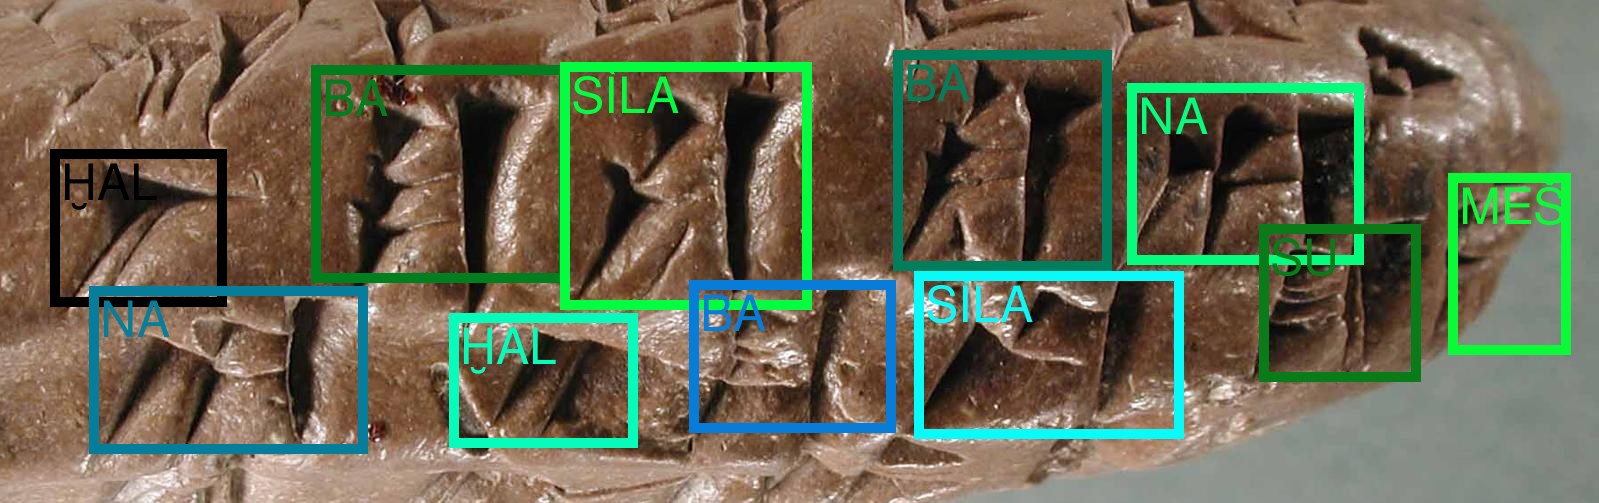

In [8]:
# ground truth boxes from test data
# draw sign classes
gt_signs = [pfa_data_module_full.class_labels[ind] for ind in test_targets[0]["labels"].tolist()]

rescaled_image = (test_img[0]*255).to(torch.uint8)
F.to_pil_image(draw_bounding_boxes(rescaled_image,
                                   test_targets[0]["boxes"],
                                   width=10,
                                   labels=gt_signs,
                                   font="/content/fonts/FreeSans.ttf",
                                  font_size=50))

In [9]:
# run inference!
preds = pipeline(test_img)

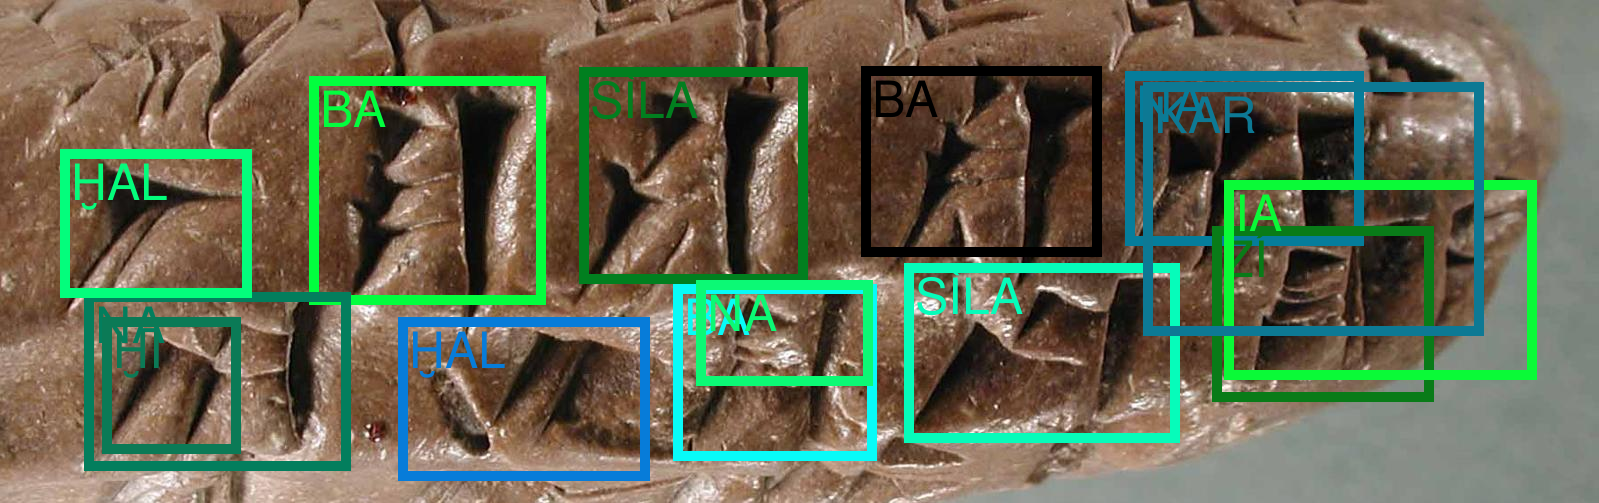

In [10]:
pred_labels = [pfa_data_module_full.class_labels[ind] for ind in preds[0]["labels"].tolist()]
# rendering with end-to-end predictions!
F.to_pil_image(draw_bounding_boxes(rescaled_image,
                                   preds[0]["boxes"],
                                   width=10,
                                   labels=pred_labels,
                                   font="/content/fonts/FreeSans.ttf",
                                  font_size=50))

In [22]:
import numpy as np
import editdistance

In [26]:
# what about the complete sentence transliteration?
pred_order = list(np.array(pred_labels)[np.array(preds[0]["ordering"])])
# not bad - but this is a pretty small tablet with only two straight lines. 
print(pred_order)
print(gt_signs)
# as you can tell from the picture, it's not terrible - although insertions and overlapping
# signs throw off the character error rate (CER). For large, multi-line tablets, this can 
# severely impact performance end-to-end even if the average sign prediction is good. 
print(editdistance.eval(pred_order, gt_signs) /len(gt_signs))

['ḪAL', 'BA', 'SÌLA', 'BA', 'NA', 'KAR', 'ḪI', 'NA', 'ḪAL', 'BA', 'NA', 'SÌLA', 'ZÍ', 'IA']
['ḪAL', 'BA', 'SÌLA', 'BA', 'NA', 'NA', 'ḪAL', 'BA', 'SÌLA', 'SU', 'MEŠ']
0.45454545454545453
